In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense,  AvgPool2D, Reshape, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
##from google.colab import drive
##drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
os.getcwd()

'd:\\ComputerVision\\GProject'

In [3]:
path = 'newdata/train'

In [4]:
classes  = os.listdir(path)

In [5]:
classes

['bloodcontent', 'personaldata', 'safe', 'violence']

In [6]:
print(os.getcwd())

d:\ComputerVision\GProject


In [9]:
classes

['safe', 'personaldata', 'bloodcontent', 'violence']

In [10]:
print(os.getcwd())

g:\My Drive\project


In [8]:
train_path = 'newdata/train'
test_path = 'newdata/test'
val_path = 'newdata/val'

In [9]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=classes, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=val_path, target_size=(224,224), classes=classes, batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=test_path, target_size=(224,224), classes=classes, batch_size=10, shuffle=False)

Found 2912 images belonging to 4 classes.
Found 831 images belonging to 4 classes.
Found 416 images belonging to 4 classes.


In [10]:
imgs, labels = next(train_batches)

In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

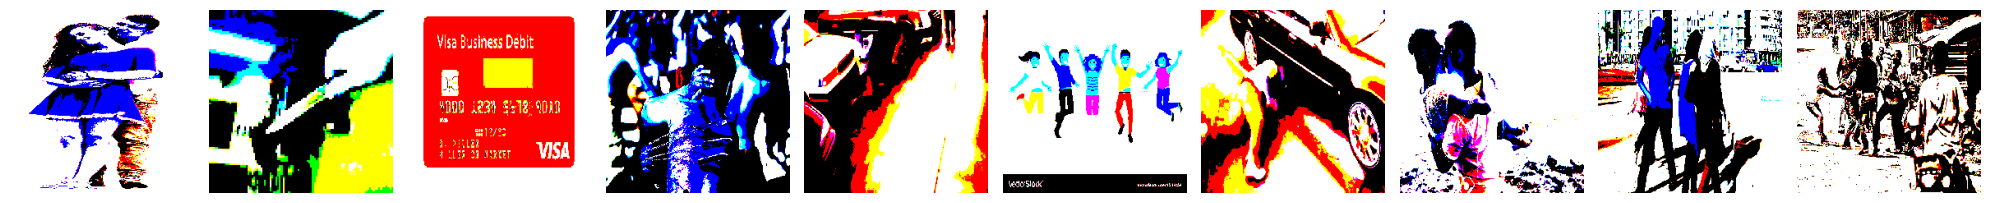

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [12]:
plotImages(imgs)
print(labels)

### Build Fine_tuned VGG16 model

In [24]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [25]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [41]:
x = vgg16_model.layers[-5].output
x1 = Flatten(data_format=None)(x)
x2 = Dropout(.7)(x1)
output = Dense(units=4, activation='softmax')(x2)

In [42]:
model= Model(inputs=vgg16_model.input, outputs=output)

In [43]:
for layer in model.layers[:20]:
    layer.trainable = False

In [44]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Train the fine_tuned VGG16 model

In [45]:
model.compile(optimizer=Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
logdir='logs'

In [47]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [48]:
#Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("vgg4classes.h5", save_best_only=True)

In [49]:
hist = model.fit(x=train_batches, validation_data=valid_batches, epochs=20, verbose=2,callbacks=[early_stopping, model_checkpoint])
 

Epoch 1/20


d:\ComputerVision\GProject\venv\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


292/292 - 463s - loss: 11.2043 - accuracy: 0.5862 - val_loss: 2.6915 - val_accuracy: 0.8556 - 463s/epoch - 2s/step
Epoch 2/20
292/292 - 460s - loss: 4.8878 - accuracy: 0.7905 - val_loss: 2.2843 - val_accuracy: 0.8833 - 460s/epoch - 2s/step
Epoch 3/20
292/292 - 473s - loss: 3.5954 - accuracy: 0.8427 - val_loss: 2.4750 - val_accuracy: 0.8845 - 473s/epoch - 2s/step
Epoch 4/20
292/292 - 488s - loss: 2.3470 - accuracy: 0.8856 - val_loss: 2.0871 - val_accuracy: 0.9037 - 488s/epoch - 2s/step
Epoch 5/20
292/292 - 502s - loss: 1.7959 - accuracy: 0.8997 - val_loss: 2.0780 - val_accuracy: 0.9097 - 502s/epoch - 2s/step
Epoch 6/20
292/292 - 523s - loss: 1.6310 - accuracy: 0.9145 - val_loss: 2.0141 - val_accuracy: 0.9146 - 523s/epoch - 2s/step
Epoch 7/20
292/292 - 559s - loss: 1.0733 - accuracy: 0.9327 - val_loss: 1.9962 - val_accuracy: 0.9194 - 559s/epoch - 2s/step
Epoch 8/20
292/292 - 523s - loss: 1.2290 - accuracy: 0.9286 - val_loss: 1.9767 - val_accuracy: 0.9122 - 523s/epoch - 2s/step
Epoch 9/20


# 8. Plot Performance-******

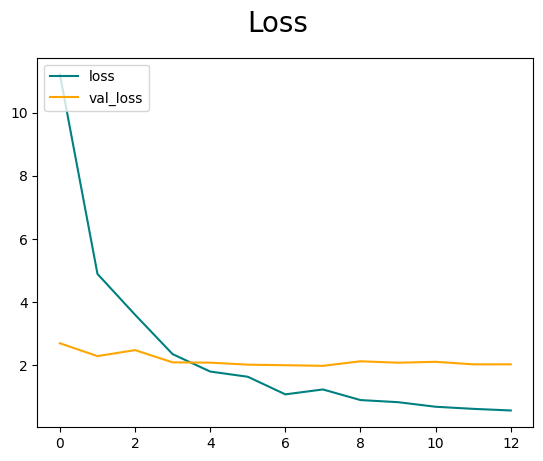

In [50]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

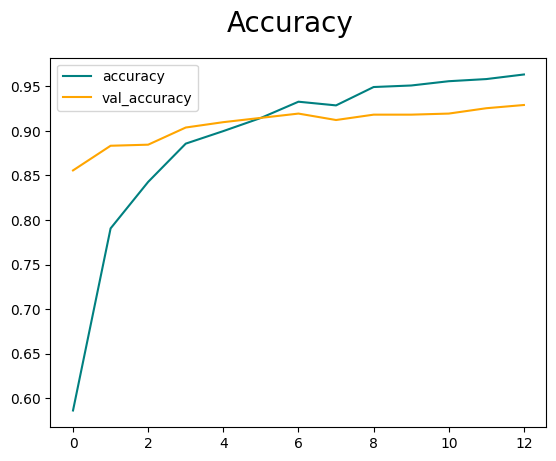

In [51]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

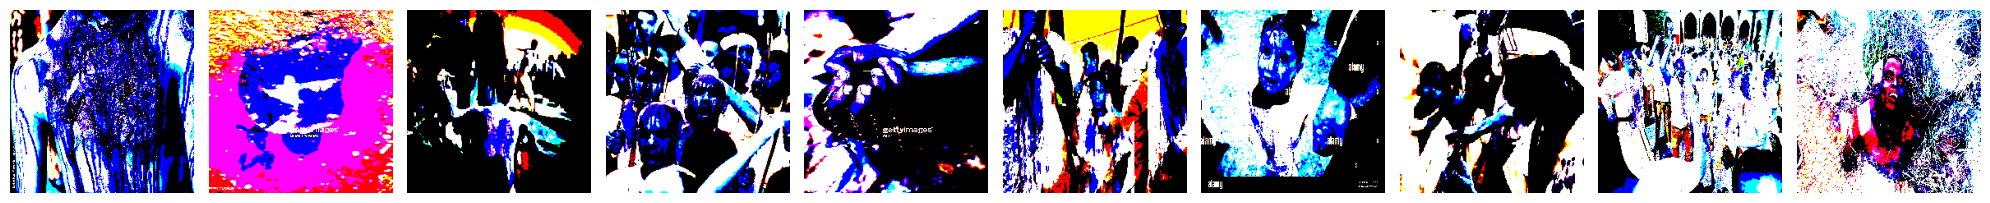

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [52]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [53]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [54]:
predictions = model.predict(x=test_batches, verbose=0)

In [55]:
rounded_predictions = np.argmax(predictions, axis = 1)
rounded_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2,
       0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
       3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3,

## Confusion Matrix

In [56]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [57]:
cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)

In [58]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)
    
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        

Confusion matrix, without normalization
[[ 71   0   9   4]
 [  1  89   0   0]
 [  3   1  86   5]
 [  4   1  10 132]]


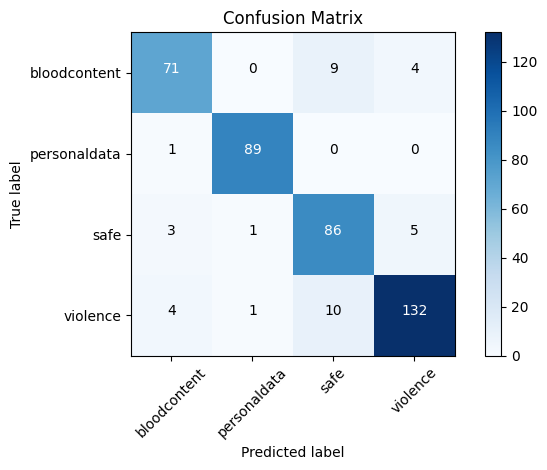

In [59]:
cm_plot_labels = classes
plot_confusion_matrix(cm, classes= cm_plot_labels,title='Confusion Matrix')

## save the model

In [46]:
import h5py
model.save("vgg4classes.h5")